<a href="https://colab.research.google.com/github/akshay-alpha/Deep-Learning/blob/main/Cats_vs_Dogs_Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Change the location to drive

!cd /content/drive/MyDrive/

In [ ]:
#Extract all the files from Zip
from zipfile import ZipFile

In [ ]:
with ZipFile('/content/drive/MyDrive/dogs-vs-cats.zip','r') as ZipObj:
  #Extract all contents of zip file in current directory
  ZipObj.extractall()


with ZipFile('train.zip','r') as ZipObj:
  #Extract all contents of zip file in current directory
  ZipObj.extractall()

with ZipFile('test1.zip','r') as ZipObj:
  #Extract all contents of zip file in current directory
  ZipObj.extractall() 

## Create sub directories so that data is in this format

>dataset_dogs_vs_cats
  >>Train
    >>>dogs ||
    >>>cats

  >>Test
    >>>dogs ||
    >>>cats

In [ ]:
from os import makedirs
#create directories

dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/','test/']
for subdir in subdirs:
  #create label subdirectories
  labeldirs=['dogs/','cats/']
  for labldir in labeldirs:
    newdir = dataset_home+subdir+labldir
    makedirs(newdir,exist_ok = True)

In [ ]:
#Now change your dataset to fit this format
from os import makedirs
from os import listdir
from shutil import copyfile

#create directories
from random import seed,random
seed(1)
#define ration of pictures to use for validation
val_ratio=0.25
#copy training dataset images into sub directories
src_directory = 'train'
dataset_home = 'dataset_dogs_vs_cats/'
for file in listdir(src_directory):
  src = src_directory+'/'+file
  dst_dir = 'train/'
  if random() < val_ratio:
    dst_dir = 'test/'
  if file.startswith('cat'):
    dst = dataset_home+dst_dir+'cats/'+file
    copyfile(src,dst)
  elif file.startswith('dog'):
    dst = dataset_home+dst_dir+'dogs/'+file
    copyfile(src,dst)

In [ ]:
import tensorflow as tf
#Prepare a model for transfer learning( VGG 16)

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
model = VGG16(include_top=False,input_shape=(224,224,3))

#mark loaded layers as not trainable
for layer in model.layers:
  layer.trainable = False

#add new classifier layers >> bottle neck features
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128,activation='relu',kernel_initializer='he_uniform')(flat1)
output = Dense(1,activation='sigmoid')(class1)

#define new model
model = Model(inputs=model.inputs, outputs=output)

#compile model
opt = tf.keras.optimizers.SGD(learning_rate = 0.001, momentum= 0.9)
model.compile(optimizer=opt,loss = 'binary_crossentropy', metrics=['accuracy'])

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
#Run the Model Using Generator
datagen = ImageDataGenerator(featurewise_center=True)

#specify imagenet mean values for centering
datagen.mean = [123.68,116.779,103.939]
#prepare iterator
train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',class_mode='binary',batch_size=64,target_size=(224,224))
test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',class_mode='binary',batch_size=64,target_size=(224,224))


Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


In [ ]:
#fitmodel
history  = model.fit_generator(train_it,steps_per_epoch=len(train_it),validation_data=test_it,validation_steps=len(test_it),epochs=5,verbose=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
293/293 [==============================] - 263s 850ms/step - loss: 0.2812 - accuracy: 0.9619 - val_loss: 0.0990 - val_accuracy: 0.9737
Epoch 2/5
293/293 [==============================] - 235s 802ms/step - loss: 0.0279 - accuracy: 0.9898 - val_loss: 0.1138 - val_accuracy: 0.9764
Epoch 3/5
293/293 [==============================] - 227s 773ms/step - loss: 0.0079 - accuracy: 0.9980 - val_loss: 0.1307 - val_accuracy: 0.9748
Epoch 4/5
293/293 [==============================] - 222s 758ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.1432 - val_accuracy: 0.9746
Epoch 5/5
293/293 [==============================] - 222s 757ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.1514 - val_accuracy: 0.9754


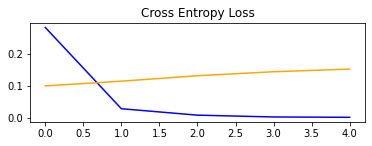

In [ ]:
# Plot the Loss and Accuracy

import matplotlib.pyplot as pyplot
import sys
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'],color='blue',label='train')
pyplot.plot(history.history['val_loss'],color='orange',label='test')

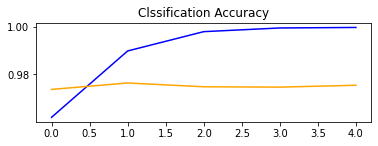

In [ ]:
# Plot accuracy
pyplot.subplot(212)
pyplot.title('Clssification Accuracy')
pyplot.plot(history.history['accuracy'],color='blue',label='train')
pyplot.plot(history.history['val_accuracy'],color='orange',label='test')

In [ ]:
#Save the plot to file
filename = sys.argv[0].split('/')[-1]
pyplot.savefig(filename+'_plot.png')


<Figure size 432x288 with 0 Axes>

In [ ]:
#Save the model for future use
model.save('final_model.h5')

In [22]:
#Predict outputs from model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

#load & prepare the image
#load the image

img = load_img('/content/dataset_dogs_vs_cats/test/dogs/dog.10019.jpg',target_size=(224,224))

#convert to array
img = img_to_array(img)
#reshape into single sample with 3 channels
img = img.reshape(1,224,224,3)
#center pixel data
img = img.astype('float32')
img = img-[123.68,116.779,103.939]


In [23]:
# 1 is for dogs and 0 is for cats

result = model.predict(img)
print(result[0])

[1.]
